**Sentiment Analysis using Python**

In [ ]:
import pandas as pd
df = pd.read_csv('Tweets.csv')

 Data Preprocessing

In [ ]:
review_df = df[['text','airline_sentiment']]
print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


We only need the text and sentiment column.

In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']
print(review_df.shape)
review_df.head(5)


(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


We don’t really need neutral reviews in our dataset for this binary classification problem. So, drop those rows from the dataset.



In [ ]:
review_df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Check the values of the airline_sentiment column.

In [ ]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 2, 0]),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

retrieve all the text data from the dataset.

In [ ]:
tweet = review_df.text.values

In tokenization, we break down all the words/sentences of a text into small parts called tokens

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

replace the words with their assigned numbers using the text_to_sequence() method.

In [ ]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

Each of the sentences in the dataset is not of equal length. Use padding to pad the sentences to have equal length.



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

Build the Text Classifier

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

vocab_size = len(tokenizer.word_index) + 1
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
________________________________________________

Train the sentiment analysis model

In [ ]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 67s 218ms/step - loss: 0.3997 - accuracy: 0.8352 - val_loss: 0.2139 - val_accuracy: 0.9125
Epoch 2/5
289/289 [==============================] - 64s 220ms/step - loss: 0.2208 - accuracy: 0.9132 - val_loss: 0.1661 - val_accuracy: 0.9381
Epoch 3/5
289/289 [==============================] - 63s 218ms/step - loss: 0.1755 - accuracy: 0.9352 - val_loss: 0.1757 - val_accuracy: 0.9285
Epoch 4/5
289/289 [==============================] - 63s 219ms/step - loss: 0.1385 - accuracy: 0.9474 - val_loss: 0.1635 - val_accuracy: 0.9446
Epoch 5/5
289/289 [==============================] - 63s 218ms/step - loss: 0.1180 - accuracy: 0.9580 - val_loss: 0.1706 - val_accuracy: 0.9398


Let’s plot these metrics using the matplotlib

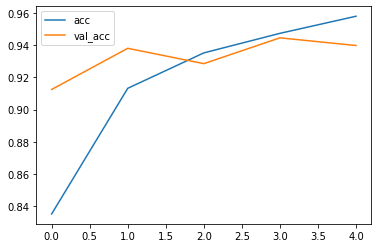

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

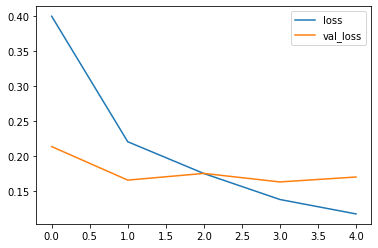

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

Let’s execute sentiment analysis model

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  positive
Predicted label:  negative
